# Processing mixed beverage data
This Jupyter Notebook uses [Mixed Beverage Gross Receipts](https://comptroller.texas.gov/taxes/mixed-beverage/receipts.php) files that were once stored on the Texas Comptroller's [data center](https://comptroller.texas.gov/transparency/open-data/search-datasets/), and then a python library called [agate](http://agate.readthedocs.io/) to clean and process that data for [stories similar to this one](http://www.mystatesman.com/business/austin-alcohol-sales-percent-february/Oo2txZUkuDlqBl0rU9O1lJ/) on monthly alcohol sales.

The Comptroller has since changed the data and storage. See the **Mixed Beverages agate-new** notebook.

- [Top sales statewide](#Top-sales-statewide)
- [Austin sales](#Austin-sales-and-sums)
- [Central Texas cities](#More-Central-Texas-cities)



### Downloading the file

If you know the url of the file on the internet, it is possible to download the file as part of the script. This is commented out since the data has been removed.

In [89]:
%%bash
## downloads the mixedbev file
## You have to set this URL based on the data center
## curl -O https://comptroller.texas.gov/auto-data/odc/MIXEDBEV_04_2017.CSV


There is supposedly a way to call a file from a [remote url](http://agate-remote.readthedocs.io/en/0.2.0/) into agate, but I use bash above to curl the file and store it locally instead.

Next, we'll use a bash command to peek at the data, which we know is a mess:

In [90]:
%%bash
head -n 5 MIXEDBEV_04_2017.CSV

"MB821424    ","ABI-HAUS                      ","959 N 2ND ST                  ","ABILENE             ","TX","79601","221","          ","2017/02", 000000632.34
"MB638028    ","ABILENE BEEHIVE INC           ","442 CEDAR ST STE A            ","ABILENE             ","TX","79601","221","          ","2017/03", 000002472.16
"MB543114    ","ABILENE BOWLING LANES INC     ","279 RUIDOSA AVE               ","ABILENE             ","TX","79605","221","          ","2017/03", 000000295.67
"MB933130    ","ABILENE CABARET LLC           ","1918 BUTTERNUT ST             ","ABILENE             ","TX","79602","221","          ","2017/03", 000000806.34
"N 037863    ","ABILENE COUNTRY CLUB          ","4039 S TREADAWAY BLVD         ","ABILENE             ","TX","79602","221","          ","2017/03", 000001583.54


Now that we have our file and know what it looks like, we'll use Python and the agate library to clean and analyze it. You'll need to make sure that you have agate installed, preferably in an virtual environment like Conda, as described in the [ReadMe](README.md).

In [91]:
# imports the libraries we will use
import agate
from decimal import Decimal
import re

In [92]:
# this surpresses the timezone warning
# Might comment out during development so other warnings
# are not surpressed
import warnings
warnings.filterwarnings('ignore')

### Study variables

This is where you set which file you are working with, and which month you want to study, etc.

First, we'll list the files in our directory that we have downloaded so far so we can get the filename:

In [93]:
ls

MIXEDBEV_02_2017.CSV             README.md
MIXEDBEV_03_2017.CSV             counties.csv
MIXEDBEV_04_2015.CSV             data-raw/
MIXEDBEV_04_2016.CSV             headers.txt
MIXEDBEV_04_2017.CSV             mixbev-env.txt
Mixed beverages agate-new.ipynb  mixbev-pip.txt
Mixed beverages agate.ipynb


Then we set some values based on those.

- The **`file`** is the name of the file we want to process
- The **`tax_rate`** is the value we need for this file to get the Gross Recipts (vs the Tax Reported, which is just the tax amount the establishment paid). The comptroller [has information on the tax](https://comptroller.texas.gov/taxes/mixed-beverage/receipts.php), but this [old record layout](https://github.com/utdata/cli-tools/blob/master/data/mixbevtax/OLD-MIXEDBEVTAX-LAYOUT.txt) best describes the math.
- The **`month_studied`** is the YYYY/MM designation for the month before the file release. The file released in February has mostly records from January, but can also have any other month, so we set here the specific month we want. Note there is a check later on that counts the number of files by month, which is worth checking.

In [94]:
# this is our source file, which may have been downloaded above
file = 'MIXEDBEV_04_2017.CSV'

# Sets the tax rate to convert Report Tax to Gross Receipts
# It's 6.7 since January 1, 2014
tax_rate = Decimal('6.7')

# setting the month_studied var.
# This should be checked in the table below that counts records by month
month_studied = '2017/03'


### Import the file
There are a couple of things we have to set to import a file. Remember we had to do the same when we did this manually in Tableau.
- Set the column header names
- Set the ZIP can County codes as text, so we preserve '001'.
- The encoding type of the file (Tableau enferred, but we have to specify here. Common types are 'iso-8859-1' or  'utf-8', or 'latin1'. Just try it until it works.

In [95]:
# sets the column names of the original data set.
column_names = [
    'TABC Permit Number',
    'Trade Name',
    'Location Address',
    'Location City',
    'Location State',
    'Location Zip Code',
    'Location County Code',
    'Blank',
    'Report Period',
    'Report Tax'
]
# Helps us import some text fields that may be considered numbers in error.
specified_types = {
    'Location Zip Code': agate.Text(),
    'Location County Code': agate.Text()
}

# this imports the file specified above, along with the proper types
mixbev_raw = agate.Table.from_csv(file, column_names, encoding='iso-8859-1', column_types=specified_types)

# prints table fields so we an check thoes data types
print(mixbev_raw)

| column               | data_type |
| -------------------- | --------- |
| TABC Permit Number   | Text      |
| Trade Name           | Text      |
| Location Address     | Text      |
| Location City        | Text      |
| Location State       | Text      |
| Location Zip Code    | Text      |
| Location County Code | Text      |
| Blank                | Boolean   |
| Report Period        | Text      |
| Report Tax           | Number    |



### Clean up text fields and compute gross receipts

In [96]:
# mixbev_trim creates a new interim table with results of compute function
# that takes the four columns that need trimming and strips them of white space,
# adding them to the end of the table with new names.
# The last computation does the math to create the Gross Receipts based on the tax_rate set above

mixbev_trim = mixbev_raw.compute([
    ('Permit', agate.Formula(agate.Text(), lambda r: r['TABC Permit Number'].strip())),
    ('Name', agate.Formula(agate.Text(), lambda r: r['Trade Name'].strip())),
    ('Address', agate.Formula(agate.Text(), lambda r: r['Location Address'].strip())),
    ('City', agate.Formula(agate.Text(), lambda r: r['Location City'].strip())),
    ('Receipts_compute', agate.Formula(agate.Number(), lambda r: (r['Report Tax'] / tax_rate) * 100))
])

# the Receipts_compute computation above returns as a decimal number,
# so this function rounds those numbers.
# I might refactor this late so I can use it elsewhere.
def round_receipt(row):
    return row['Receipts_compute'].quantize(Decimal('0.01'))

# This compute method uses round_recipt function above,
# putting the results into a new table.
mixbev_round = mixbev_trim.compute([
    ('Receipts', agate.Formula(agate.Number(), round_receipt))
])

## shows the new columns added to the interim table
print(mixbev_round)

| column               | data_type |
| -------------------- | --------- |
| TABC Permit Number   | Text      |
| Trade Name           | Text      |
| Location Address     | Text      |
| Location City        | Text      |
| Location State       | Text      |
| Location Zip Code    | Text      |
| Location County Code | Text      |
| Blank                | Boolean   |
| Report Period        | Text      |
| Report Tax           | Number    |
| Permit               | Text      |
| Name                 | Text      |
| Address              | Text      |
| City                 | Text      |
| Receipts_compute     | Number    |
| Receipts             | Number    |



In [97]:
# creates new table, selecting just the columns we need
# then renames some of them for ease later.
mixbev_cleaned = mixbev_round.select([
    'Permit',
    'Name',
    'Address',
    'City',
    'Location State',
    'Location Zip Code',
    'Location County Code',
    'Report Period',
    'Report Tax',
    'Receipts'
]).rename(column_names = {
    'Location State': 'State',
    'Location Zip Code': 'Zip',
    'Location County Code': 'CountyCode',
    'Report Period': 'Period',
    'Report Tax': 'Tax'
})

## these are now the columns present in our new, cleaned table
print(mixbev_cleaned)

| column     | data_type |
| ---------- | --------- |
| Permit     | Text      |
| Name       | Text      |
| Address    | Text      |
| City       | Text      |
| State      | Text      |
| Zip        | Text      |
| CountyCode | Text      |
| Period     | Text      |
| Tax        | Number    |
| Receipts   | Number    |



In [98]:
# and this peeks at a couple of columns the data (Tax and Receipts)
# to make sure they make sense and the math is right
# During development, I did send this to_csv and made sure columns were trimmed, etc
mixbev_cleaned.select(['Tax','Receipts']).limit(5).print_table()

|      Tax |  Receipts |
| -------- | --------- |
| 2,472.16 | 36,897.91 |
|   295.67 |  4,412.99 |
|   806.34 | 12,034.93 |
| 1,583.54 | 23,634.93 |
| 1,113.47 | 16,618.96 |


### Create establishment column

We do this so we make sure we have single establishments instead of grouping trade names together from different addresses, like 'CHILI'S BAR & GRILL'.

In [99]:
# Concatenates the name and address
mixbev_cleaned_est = mixbev_cleaned.compute([
    ('Establishment', agate.Formula(agate.Text(), lambda row: '%(Name)s %(Address)s' % row))
])

# Prints columns so you see it is there
print(mixbev_cleaned_est)

| column        | data_type |
| ------------- | --------- |
| Permit        | Text      |
| Name          | Text      |
| Address       | Text      |
| City          | Text      |
| State         | Text      |
| Zip           | Text      |
| CountyCode    | Text      |
| Period        | Text      |
| Tax           | Number    |
| Receipts      | Number    |
| Establishment | Text      |



In [100]:
# selects and prints Establishment to check what is looks like
mixbev_establishment = mixbev_cleaned_est.select('Establishment')
mixbev_establishment.limit(5).print_table(max_column_width=80)

| Establishment                              |
| ------------------------------------------ |
| ABILENE BEEHIVE INC 442 CEDAR ST STE A     |
| ABILENE BOWLING LANES INC 279 RUIDOSA AVE  |
| ABILENE CABARET LLC 1918 BUTTERNUT ST      |
| ABILENE COUNTRY CLUB 4039 S TREADAWAY BLVD |
| ABILENE SEAFOOD TAVERN 1882 S CLACK ST     |


### Import and merge counties lookup table
We do this to get county names. I got this list from the comptroller.

In [101]:
# importing countes.csv, ensuring that the 'code' column is text
counties = agate.Table.from_csv('counties.csv', column_types={'code': agate.Text()})

# peek at the column names
print(counties)

| column | data_type |
| ------ | --------- |
| id     | Number    |
| county | Text      |
| code   | Text      |



In [102]:
# peek at the data
counties.limit(5).print_table()

| id | county   | code |
| -- | -------- | ---- |
|  1 | Anderson | 001  |
|  2 | Andrews  | 002  |
|  3 | Angelina | 003  |
|  4 | Aransas  | 004  |
|  5 | Archer   | 005  |


In [103]:
# joines the counties table to the mixed bev cleaned data with establishments
mixbev_joined = mixbev_cleaned_est.join(counties, 'CountyCode', 'code')

# check that the merge was succesful 
print(mixbev_joined)

| column        | data_type |
| ------------- | --------- |
| Permit        | Text      |
| Name          | Text      |
| Address       | Text      |
| City          | Text      |
| State         | Text      |
| Zip           | Text      |
| CountyCode    | Text      |
| Period        | Text      |
| Tax           | Number    |
| Receipts      | Number    |
| Establishment | Text      |
| id            | Number    |
| county        | Text      |



In [104]:
# get just the columns we need and rename county
# THIS is the finished, cleaned mixbev table
mixbev = mixbev_joined.select([
    'Permit',
    'Name',
    'Address',
    'Establishment',
    'City',
    'State',
    'Zip',
    'county',
    'Period',
    'Tax',
    'Receipts'
]).rename(column_names = {
    'county': 'County'
})

# peek at the column names
print(mixbev)

| column        | data_type |
| ------------- | --------- |
| Permit        | Text      |
| Name          | Text      |
| Address       | Text      |
| Establishment | Text      |
| City          | Text      |
| State         | Text      |
| Zip           | Text      |
| County        | Text      |
| Period        | Text      |
| Tax           | Number    |
| Receipts      | Number    |



In [105]:
# peek at the table
mixbev.limit(5).print_table()

| Permit   | Name                 | Address              | Establishment        | City    | State | ... |
| -------- | -------------------- | -------------------- | -------------------- | ------- | ----- | --- |
| MB638028 | ABILENE BEEHIVE INC  | 442 CEDAR ST STE A   | ABILENE BEEHIVE I... | ABILENE | TX    | ... |
| MB543114 | ABILENE BOWLING L... | 279 RUIDOSA AVE      | ABILENE BOWLING L... | ABILENE | TX    | ... |
| MB933130 | ABILENE CABARET LLC  | 1918 BUTTERNUT ST    | ABILENE CABARET L... | ABILENE | TX    | ... |
| N 037863 | ABILENE COUNTRY CLUB | 4039 S TREADAWAY ... | ABILENE COUNTRY C... | ABILENE | TX    | ... |
| MB200506 | ABILENE SEAFOOD T... | 1882 S CLACK ST      | ABILENE SEAFOOD T... | ABILENE | TX    | ... |


### Looking at dates of the records

Here we are looking at the entire mixbev table to see what range of dates we have. This way we can make sure we are analyzing the correct month based on this data. (More than one month can be present, but it will be predominately the previous month).

To explain what we are doing here, as it is kind of obtuse in agate:
- use group_by to create a tableset by the Period field.
- Create a table and set it it based on counting the number of records for each Period.
- create a table to then sort the period in reverse order to put the dominate month at the top
- Then print the sorted table (top 10 rows)

In [106]:
# this is the group_by
by_period = mixbev.group_by('Period')

# Then aggregate that group by count of records in Period
period_totals = by_period.aggregate([
    ('count', agate.Count())
])

# Take those results and sort them
period_totals_sorted = period_totals.order_by('count', reverse=True)

# prints the table of period and number of records
period_totals_sorted.print_table(max_rows=None)


| Period  |  count |
| ------- | ------ |
| 2017/03 | 14,144 |
| 2017/02 |  1,718 |
| 2017/01 |    258 |
| 2016/12 |     61 |
| 2017/04 |     49 |
| 2016/11 |     44 |
| 2016/10 |     32 |
| 2016/09 |     25 |
| 2016/08 |     23 |
| 2016/07 |     17 |
| 2016/01 |     13 |
| 2016/02 |     13 |
| 2016/05 |     13 |
| 2016/06 |     13 |
| 2016/03 |     12 |
| 2016/04 |     12 |
| 2015/11 |     12 |
| 2015/12 |     12 |
| 2015/10 |     11 |
| 2015/09 |      9 |
| 2015/06 |      8 |
| 2015/07 |      8 |
| 2015/08 |      8 |
| 2015/02 |      7 |
| 2015/03 |      7 |
| 2015/05 |      6 |
| 2014/07 |      6 |
| 2014/09 |      6 |
| 2014/10 |      6 |
| 2015/01 |      6 |
| 2015/04 |      6 |
| 2014/05 |      4 |
| 2014/06 |      4 |
| 2014/08 |      4 |
| 2014/11 |      4 |
| 2014/12 |      4 |
| 2013/11 |      4 |
| 2014/04 |      3 |
| 2013/04 |      3 |
| 2013/05 |      3 |
| 2013/06 |      3 |
| 2013/07 |      3 |
| 2013/08 |      3 |
| 2013/09 |      3 |
| 2013/10 |      3 |
| 2013/12 |  

The top value in the table above is typically the month before the reporting date. This also shows how many records are filed for OTHER months. We want to make sure the top month value is included as the **month_studied** variable at the top of this file.

So, now we can filter the data to our specific month, which will use for the rest of the analysis:

In [107]:
## filters the records to our month_studied
mixbev_month = mixbev.where(lambda row: row['Period'] == month_studied)

## The number of records in our month
len(mixbev_month)

14144

## Top sales statewide

Because we want to group our results by more than one field and perform more than one aggregation, we'll do this a little differently. We'll use group_by to create a grouped table, then perform aggregations on that new table to computer the Tax and Receipts columns.

In [108]:
# groups the data based on Establishment and City
mixbev_grouped = mixbev_month.group_by('Establishment').group_by('County').group_by('City')

# computes the sales based on the grouping
state_summary = mixbev_grouped.aggregate([
    ('Tax_sum', agate.Sum('Tax')),
    ('Sales_sum', agate.Sum('Receipts'))
])

# sorts the results by most sold. We could probalby chain it above if we wanted to.
state_summary_sorted = state_summary.order_by('Sales_sum', reverse=True)

# prints the top 10 results
state_summary_sorted.limit(10).print_table(max_column_width=40)

| Establishment                            | County  | City        |    Tax_sum |    Sales_sum |
| ---------------------------------------- | ------- | ----------- | ---------- | ------------ |
| THREE NRG PARK 2000 SOUTH LOOP W         | Harris  | HOUSTON     | 251,360.81 | 3,751,653.88 |
| ARAMARK SPORTS AND ENTERTAINME 211 AT... | Bexar   | SAN ANTONIO | 127,188.37 | 1,898,333.88 |
| GAYLORD TEXAN 1501 GAYLORD TRL           | Tarrant | GRAPEVINE   | 106,811.33 | 1,594,198.96 |
| HOSPITALITY INTERNATIONAL, INC 23808 ... | Bexar   | SAN ANTONIO | 102,455.66 | 1,529,188.96 |
| LEVY RESTAURANTS AT TOYOTA CEN 1510 P... | Harris  | HOUSTON     |  79,008.41 | 1,179,230.00 |
| SALC, INC. 2201 N STEMMONS FWY FL 1      | Dallas  | DALLAS      |  75,850.63 | 1,132,098.96 |
| WLS BEVERAGE CO 110 E 2ND ST             | Travis  | AUSTIN      |  75,785.84 | 1,131,131.94 |
| OMNI DALLAS CONVENTION CENTER 555 S L... | Dallas  | DALLAS      |  64,926.48 |   969,051.94 |
| LEVY RESTAURANTS 2500 VICTOR

## Overall statewide sum

In [109]:
# summing sales statewide for month
mixbev_month.aggregate(agate.Sum('Receipts'))

Decimal('589318616.73')

## Location sums function

Because we want to get the top sellers in a bunch of cities and couties, we create a function so we don't have to repeat the code. This function allows us to pass in a city or county name to filter the monthly receipts table and then sum the Tax and Receipts columns. The result can then be acted on to print or aggreggate.

In [110]:
# function to group sales by a specific location
# City or County passed in should be ALL CAPS
# Location_type can be 'City' or 'County'

def location_sum(location_type, location):
    # Filters the data to the specified city
    location_filtered = mixbev_month.where(lambda row: row[location_type].upper() == location)

    # groups the data based on Establishment and location
    location_grouped = location_filtered.group_by('Establishment').group_by(location_type)
    # computes the sales based on the grouping
    location_summary = location_grouped.aggregate([
        ('Tax_sum', agate.Sum('Tax')),
        ('Receipts_sum', agate.Sum('Receipts'))
    ])
    
    # sorts the results by most sold
    location_summary_sorted = location_summary.order_by('Receipts_sum', reverse=True)
    # prints the top 10 results
    
    return(location_summary_sorted)


## Austin sales and sums

With this, we refernce the location_sum function above, and pass the type of location (City) and the name of the city (AUSTIN). At the same time, we limit the result of that function to the first 10 records, and then print the results. We are basically stringing together a bunch of stuff at once.

In [111]:
# uses the city_sum function to filter
austin = location_sum('City', 'AUSTIN')

# print the resulting table
austin.limit(5).print_table(max_column_width=60)

| Establishment                                      | City   |   Tax_sum | Receipts_sum |
| -------------------------------------------------- | ------ | --------- | ------------ |
| WLS BEVERAGE CO 110 E 2ND ST                       | AUSTIN | 75,785.84 | 1,131,131.94 |
| 400 BAR/CUCARACHA/CHUPACABRA/J 400 E 6TH ST        | AUSTIN | 43,934.51 |   655,738.96 |
| SAN JACINTO BEVERAGE COMPANY L 98 SAN JACINTO BLVD | AUSTIN | 37,672.15 |   562,270.90 |
| RAIN ON 4TH 217 W 4TH ST STE B                     | AUSTIN | 36,828.02 |   549,671.94 |
| THE BLIND PIG PUB 317 E 6TH ST                     | AUSTIN | 32,472.48 |   484,663.88 |


### String methods together to print a table
So far, we've been printing tables, but Agate can also print charts. The **`print_bars`** method creates a simple, text-based bar chart.

In [112]:
# We'll use the same function, but instead of creating a new table,
# we'll just string on the limit and print bars methods
# print_bars needs to arguments, the label column and then the value to make the chart from
location_sum('City', 'AUSTIN').limit(10).print_bars('Establishment', 'Receipts_sum', width=90)

Establishment                                      Receipts_sum
WLS BEVERAGE CO 110 E 2ND ST                       1,131,131.94 ▓░░░░░░░░░░░░░░           
400 BAR/CUCARACHA/CHUPACABRA/J 400 E 6TH ST          655,738.96 ▓░░░░░░░░                 
SAN JACINTO BEVERAGE COMPANY L 98 SAN JACINTO BLVD   562,270.90 ▓░░░░░░░                  
RAIN ON 4TH 217 W 4TH ST STE B                       549,671.94 ▓░░░░░░░                  
THE BLIND PIG PUB 317 E 6TH ST                       484,663.88 ▓░░░░░░                   
ROSE ROOM/ 77 DEGREES 11500 ROCK ROSE AVE            477,230.90 ▓░░░░░░                   
CONTAINER BAR 90 RAINEY ST                           468,865.97 ▓░░░░░░                   
W HOTEL AUSTIN 200 LAVACA ST                         440,127.91 ▓░░░░░░                   
DH BEVERAGE LLC 604 BRAZOS ST                        428,531.94 ▓░░░░░                    
TOP GOLF 2700 ESPERANZA XING                         418,343.88 ▓░░░░░                    
                          

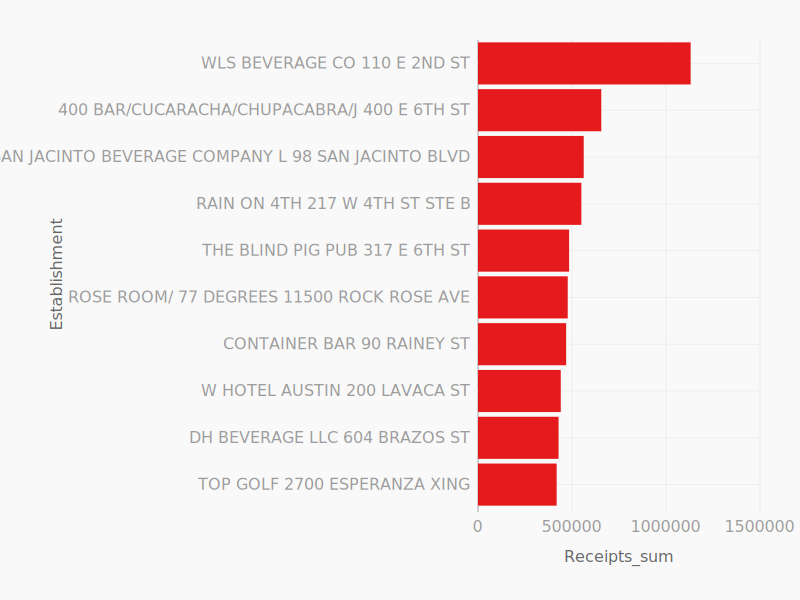

In [113]:
# You can even print simple charts with leather, which is built in.
# There are more advance charting libraries that can integrate with agate
location_sum('City', 'AUSTIN').limit(10).bar_chart('Establishment', 'Receipts_sum')

### Total sales Austin

In [114]:
# Austin total sales as s city
# This sums the grouped table, but it works
location_sum('City', 'AUSTIN').aggregate(agate.Sum('Receipts_sum'))

Decimal('75059310.65')

## More Central Texas cities

In [115]:
location_sum('City', 'BASTROP').limit(5).print_table(max_column_width=60)

| Establishment                              | City    |  Tax_sum | Receipts_sum |
| ------------------------------------------ | ------- | -------- | ------------ |
| OLD TOWN RESTURANT AND BAR/PIN 931 MAIN ST | BASTROP | 5,095.81 |    76,056.87 |
| CHILI'S GRILL & BAR 734 HIGHWAY 71 W       | BASTROP | 2,838.38 |    42,363.88 |
| NEIGHBOR'S 601 CHESTNUT ST UNIT C          | BASTROP | 2,812.92 |    41,983.88 |
| BACK 9 834 HIGHWAY 71 W                    | BASTROP | 2,425.26 |    36,197.91 |
| LA HACIENDA RESTAURANT 1800 WALNUT ST      | BASTROP | 2,250.53 |    33,590.00 |


In [116]:
location_sum('City', 'BEE CAVE').limit(3).print_table(max_column_width=60)

| Establishment                                       | City     |  Tax_sum | Receipts_sum |
| --------------------------------------------------- | -------- | -------- | ------------ |
| HCG BEVERAGE, LLC 12525 BEE CAVE PKWY               | BEE CAVE | 6,331.63 |    94,501.94 |
| WOODY TAVERN AND GRILL, INC. 12801 SHOPS PKWY # 100 | BEE CAVE | 6,323.46 |    94,380.00 |
| MAUDIE'S HILL COUNTRY, LLC 12506 SHOPS PKWY         | BEE CAVE | 5,968.29 |    89,078.96 |


In [117]:
location_sum('City', 'BUDA').limit(3).print_table(max_column_width=60)

| Establishment                  | City |  Tax_sum | Receipts_sum |
| ------------------------------ | ---- | -------- | ------------ |
| BUCKS BACKYARD 1750 S FM 1626  | BUDA | 7,863.05 |   117,358.96 |
| WILLIE'S JOINT 824 MAIN ST     | BUDA | 4,295.03 |    64,104.93 |
| PINBALLZ KINGDOM 15201 S IH 35 | BUDA | 3,521.92 |    52,565.97 |


In [119]:
location_sum('City', 'CEDAR PARK').limit(3).print_table(max_column_width=60)

| Establishment                                          | City       |   Tax_sum | Receipts_sum |
| ------------------------------------------------------ | ---------- | --------- | ------------ |
| CHUY'S 4911 183A TOLL RD                               | CEDAR PARK | 12,001.04 |   179,120.00 |
| LUPE TORTILLA MEXICAN RESTAURA 4501 183A TOLL RD STE B | CEDAR PARK |  7,989.81 |   119,250.90 |
| RYAN SANDERS SPORTS SERVICES, 2100 AVENUE OF THE STARS | CEDAR PARK |  6,700.20 |   100,002.99 |


In [120]:
location_sum('City', 'DRIPPING SPRINGS').limit(3).print_table(max_column_width=60)

| Establishment                                       | City             |  Tax_sum | Receipts_sum |
| --------------------------------------------------- | ---------------- | -------- | ------------ |
| TRUDY'S FOUR STAR 13059 FOUR STAR BLVD              | DRIPPING SPRINGS | 4,229.71 |    63,130.00 |
| DEEP EDDY DISTILLING CO 2250 E HIGHWAY 290          | DRIPPING SPRINGS | 4,001.30 |    59,720.90 |
| FLORES MEXICAN RESTAURANT 2440 E HIGHWAY 290 BLDG D | DRIPPING SPRINGS | 3,631.73 |    54,204.93 |


In [121]:
location_sum('City', 'GEORGETOWN').limit(3).print_table(max_column_width=60)

| Establishment                      | City       |  Tax_sum | Receipts_sum |
| ---------------------------------- | ---------- | -------- | ------------ |
| EL MONUMENTO 205 W 2ND ST          | GEORGETOWN | 6,815.03 |   101,716.87 |
| HARDTAILS 1515 N IH 35             | GEORGETOWN | 4,984.66 |    74,397.91 |
| DOS SALSAS CAFE INC 1104 S MAIN ST | GEORGETOWN | 4,818.90 |    71,923.88 |


In [122]:
location_sum('City', 'KYLE').limit(3).print_table(max_column_width=60)

| Establishment                                       | City |  Tax_sum | Receipts_sum |
| --------------------------------------------------- | ---- | -------- | ------------ |
| CASA GARCIA'S MEXICAN RESTAURA 5401 FM 1626 STE 300 | KYLE | 5,228.68 |    78,040.00 |
| EVO ENTERTAINMENT CENTER 3200 KYLE XING             | KYLE | 4,822.32 |    71,974.93 |
| CENTERFIELD SPORTS BAR & GRILL 200 W CENTER ST      | KYLE | 2,941.43 |    43,901.94 |


In [123]:
location_sum('City', 'LAGO VISTA').limit(3).print_table(max_column_width=60)

| Establishment                                        | City       |  Tax_sum | Receipts_sum |
| ---------------------------------------------------- | ---------- | -------- | ------------ |
| COPPERHEAD GRILL 6115 LOHMANS FORD RD                | LAGO VISTA | 1,543.61 |    23,038.96 |
| MARIA'S BAR & GRILL MEXICAN RE 20602 FM 1431 STE 102 | LAGO VISTA |   490.10 |     7,314.93 |


In [124]:
location_sum('City', 'LAKEWAY').limit(3).print_table(max_column_width=60)

| Establishment                                        | City    |  Tax_sum | Receipts_sum |
| ---------------------------------------------------- | ------- | -------- | ------------ |
| THE GROVE WINE BAR AND KITCHEN 3001 RANCH ROAD 620 S | LAKEWAY | 7,590.96 |   113,297.91 |
| LAKEWAY RESORT AND SPA 101 LAKEWAY DR                | LAKEWAY | 6,797.01 |   101,447.91 |
| HIGH 5 ENTERTAINMENT 1502 RANCH ROAD 620 S           | LAKEWAY | 4,468.96 |    66,700.90 |


In [125]:
location_sum('City', 'LEANDER').limit(3).print_table(max_column_width=60)

| Establishment                                        | City    |  Tax_sum | Receipts_sum |
| ---------------------------------------------------- | ------- | -------- | ------------ |
| BROOKLYN HEIGHTS PIZZERIA 3550 LAKELINE BLVD STE 135 | LEANDER | 3,792.26 |    56,600.90 |
| JARDIN DEL REY 703 S HIGHWAY 183                     | LEANDER | 2,939.29 |    43,870.00 |
| TAPATIA JALISCO #3 LLC 651 N US 183                  | LEANDER |   755.42 |    11,274.93 |


In [126]:
location_sum('City', 'LIBERTY HILL').limit(3).print_table(max_column_width=60)

| Establishment                                      | City         |  Tax_sum | Receipts_sum |
| -------------------------------------------------- | ------------ | -------- | ------------ |
| JARDIN CORONA 15395 W STATE HIGHWAY 29             | LIBERTY HILL | 2,991.81 |    44,653.88 |
| MARGARITA'S RESTAURANT 10280 W STATE HIGHWAY 29    | LIBERTY HILL | 2,156.32 |    32,183.88 |
| ELENAS MEXICAN RESTAURANT 14801 W STATE HIGHWAY 29 | LIBERTY HILL |   280.32 |     4,183.88 |


In [127]:
location_sum('City', 'PFLUGERVILLE').limit(3).print_table(max_column_width=60)

| Establishment                          | City         |  Tax_sum | Receipts_sum |
| -------------------------------------- | ------------ | -------- | ------------ |
| MAVERICKS 1700 GRAND AVENUE PKWY STE 2 | PFLUGERVILLE | 7,534.15 |   112,450.00 |
| HANOVER'S DRAUGHT HAUS 108 E MAIN ST   | PFLUGERVILLE | 4,784.67 |    71,412.99 |
| LAST CALL 1615 GRAND AVENUE PKWY STE 2 | PFLUGERVILLE | 4,573.08 |    68,254.93 |


In [128]:
location_sum('City', 'ROUND ROCK').limit(5).print_table(max_column_width=60)

| Establishment                                           | City       |   Tax_sum | Receipts_sum |
| ------------------------------------------------------- | ---------- | --------- | ------------ |
| CHUY'S ROUND ROCK 2320 N INTERSTATE 35                  | ROUND ROCK | 10,927.56 |   163,097.91 |
| THIRD BASE ROUND ROCK, LLC 3107 S INTERSTATE 35 STE 810 | ROUND ROCK | 10,351.03 |   154,492.99 |
| FAST EDDIE'S NEIGHBORHOOD BILL 100 PARKER DR            | ROUND ROCK | 10,327.98 |   154,148.96 |
| RICK'S CABARET 3105 S INTERSTATE 35                     | ROUND ROCK |  9,802.36 |   146,303.88 |
| JACK ALLEN'S KITCHEN 2500 HOPPE TRL                     | ROUND ROCK |  9,461.94 |   141,222.99 |


In [129]:
location_sum('City', 'SAN MARCOS').limit(5).print_table(max_column_width=60)

| Establishment                          | City       |  Tax_sum | Receipts_sum |
| -------------------------------------- | ---------- | -------- | ------------ |
| ZELICKS 336 W HOPKINS ST               | SAN MARCOS | 9,369.34 |   139,840.90 |
| CHUY'S SAN MARCOS 1121 N INTERSTATE 35 | SAN MARCOS | 7,638.87 |   114,012.99 |
| THE MARC 120 E SAN ANTONIO ST          | SAN MARCOS | 7,286.78 |   108,757.91 |
| SEAN PATRICK'S 202 E SAN ANTONIO ST    | SAN MARCOS | 7,081.83 |   105,698.96 |
| PLUCKERS WING BAR 105 N INTERSTATE 35  | SAN MARCOS | 6,924.58 |   103,351.94 |


In [130]:
location_sum('City', 'SPICEWOOD').limit(3).print_table(max_column_width=60)

| Establishment                                      | City      |  Tax_sum | Receipts_sum |
| -------------------------------------------------- | --------- | -------- | ------------ |
| ANGEL'S ICEHOUSE 21815 W HWY 71                    | SPICEWOOD | 4,225.15 |    63,061.94 |
| POODIES HILLTOP ROADHOUSE 22308 STATE HIGHWAY 71 W | SPICEWOOD | 3,499.87 |    52,236.87 |
| APIS RESTAURANT 23526 STATE HIGHWAY 71 W           | SPICEWOOD | 2,262.45 |    33,767.91 |


In [131]:
location_sum('City', 'SUNSET VALLEY').limit(3).print_table(max_column_width=60)

| Establishment                                        | City          |  Tax_sum | Receipts_sum |
| ---------------------------------------------------- | ------------- | -------- | ------------ |
| DOC'S BACKYARD 5207 BRODIE LN # 100                  | SUNSET VALLEY | 6,248.62 |    93,262.99 |
| BJ'S RESTAURANT AND BREWHOUSE 5207 BRODIE LN STE 300 | SUNSET VALLEY | 3,561.98 |    53,163.88 |
| LONGHORN STEAKHOUSE #5423 4809 W HIGHWAY 290         | SUNSET VALLEY | 2,439.60 |    36,411.94 |


In [132]:
location_sum('City', 'WEST LAKE HILLS').limit(3).print_table(max_column_width=60)

| Establishment                                               | City            |  Tax_sum | Receipts_sum |
| ----------------------------------------------------------- | --------------- | -------- | ------------ |
| LUPE TORTILLA MEXICAN RESTAURA 701 S CAPITAL OF TEXAS HWY S | WEST LAKE HILLS | 6,853.36 |   102,288.96 |
| CHIPOTLE CHIPOTLE MEXICAN GRIL 3300 BEE CAVES RD STE 670    | WEST LAKE HILLS |    39.12 |       583.88 |


## Sales by county

In this case, we pass in the location type of 'County' and then a county name in caps to get the most sales in a particular county.

In [133]:
location_sum('County', 'BASTROP').limit(5).print_table(max_column_width=80)

| Establishment                                     | County  |   Tax_sum | Receipts_sum |
| ------------------------------------------------- | ------- | --------- | ------------ |
| LOST PINES BEVERAGE LLC 575 HYATT LOST PINES ROAD | Bastrop | 28,995.52 |   432,768.96 |
| OLD TOWN RESTURANT AND BAR/PIN 931 MAIN ST        | Bastrop |  5,095.81 |    76,056.87 |
| CHILI'S GRILL & BAR 734 HIGHWAY 71 W              | Bastrop |  2,838.38 |    42,363.88 |
| NEIGHBOR'S 601 CHESTNUT ST UNIT C                 | Bastrop |  2,812.92 |    41,983.88 |
| BACK 9 834 HIGHWAY 71 W                           | Bastrop |  2,425.26 |    36,197.91 |


In [134]:
location_sum('County', 'CALDWELL').limit(3).print_table(max_column_width=80)

| Establishment                                             | County   |  Tax_sum | Receipts_sum |
| --------------------------------------------------------- | -------- | -------- | ------------ |
| GUADALAJARA MEXICAN RESTAURANT 1710 S COLORADO ST STE 110 | Caldwell | 1,258.86 |    18,788.96 |
| THE PEARL 110 N MAIN ST                                   | Caldwell |   644.94 |     9,625.97 |
| MR TACO 1132 E PIERCE ST                                  | Caldwell |   618.61 |     9,232.99 |


In [135]:
location_sum('County', 'HAYS').limit(3).print_table(max_column_width=80)

| Establishment                          | County |  Tax_sum | Receipts_sum |
| -------------------------------------- | ------ | -------- | ------------ |
| ZELICKS 336 W HOPKINS ST               | Hays   | 9,369.34 |   139,840.90 |
| BUCKS BACKYARD 1750 S FM 1626          | Hays   | 7,863.05 |   117,358.96 |
| CHUY'S SAN MARCOS 1121 N INTERSTATE 35 | Hays   | 7,638.87 |   114,012.99 |


In [136]:
location_sum('County', 'TRAVIS').limit(3).print_table(max_column_width=80)

| Establishment                                      | County |   Tax_sum | Receipts_sum |
| -------------------------------------------------- | ------ | --------- | ------------ |
| WLS BEVERAGE CO 110 E 2ND ST                       | Travis | 75,785.84 | 1,131,131.94 |
| 400 BAR/CUCARACHA/CHUPACABRA/J 400 E 6TH ST        | Travis | 43,934.51 |   655,738.96 |
| SAN JACINTO BEVERAGE COMPANY L 98 SAN JACINTO BLVD | Travis | 37,672.15 |   562,270.90 |


In [137]:
location_sum('County', 'WILLIAMSON').limit(3).print_table(max_column_width=80)

| Establishment                                      | County     |   Tax_sum | Receipts_sum |
| -------------------------------------------------- | ---------- | --------- | ------------ |
| ALAMO DRAFTHOUSE CINEMA 14028 N HIGHWAY 183 BLDG F | Williamson | 12,676.73 |   189,204.93 |
| CHUY'S 4911 183A TOLL RD                           | Williamson | 12,001.04 |   179,120.00 |
| CHUY'S ROUND ROCK 2320 N INTERSTATE 35             | Williamson | 10,927.56 |   163,097.91 |


## Sales by ZIP Code
For this, we'll do a simple pivot on Zip, but instead of using the default Count method, we'll pass in an aggregation to add the Tax values together for all the Zips. Whe then order_by in reverse to get the top values.

In [138]:
# top zip code for Tax value
zip_tax = mixbev_month.pivot('Zip', aggregation=agate.Sum('Tax')).order_by('Sum', reverse=True)
zip_tax.limit(5).print_table()

| Zip   |          Sum |
| ----- | ------------ |
| 78701 | 2,176,967.00 |
| 78205 |   925,889.41 |
| 75201 |   767,950.37 |
| 77002 |   634,081.44 |
| 78704 |   540,209.57 |


In [139]:
# top zip code gross receipts
zip_receipts = mixbev_month.pivot('Zip', aggregation=agate.Sum('Receipts')).order_by('Sum', reverse=True)
zip_receipts.limit(5).print_table()

| Zip   |           Sum |
| ----- | ------------- |
| 78701 | 32,492,045.23 |
| 78205 | 13,819,245.15 |
| 75201 | 11,461,946.05 |
| 77002 |  9,463,902.34 |
| 78704 |  8,062,829.61 |
